In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import OneCycleLR
from model import Net
from training import train,test, train_losses, train_acc, test_losses, test_acc

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA Available")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS Available")
else:
    device = torch.device("cpu")
    print("Using CPU")

MPS Available


In [3]:
train_transforms = transforms.Compose([
                        transforms.RandomAffine(degrees=7, translate=(0.08, 0.08)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                        # ,transforms.RandomErasing(p=0.05, scale=(0.02, 0.05), ratio=(0.3, 3.3))  # tiny, optional
                        ])
test_transforms = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])

In [4]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

100%|██████████| 9.91M/9.91M [00:21<00:00, 454kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 71.0kB/s]
100%|██████████| 1.65M/1.65M [00:09<00:00, 176kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.81MB/s]


In [5]:
batch_size = 128
kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(train_data, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000, shuffle=False)

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


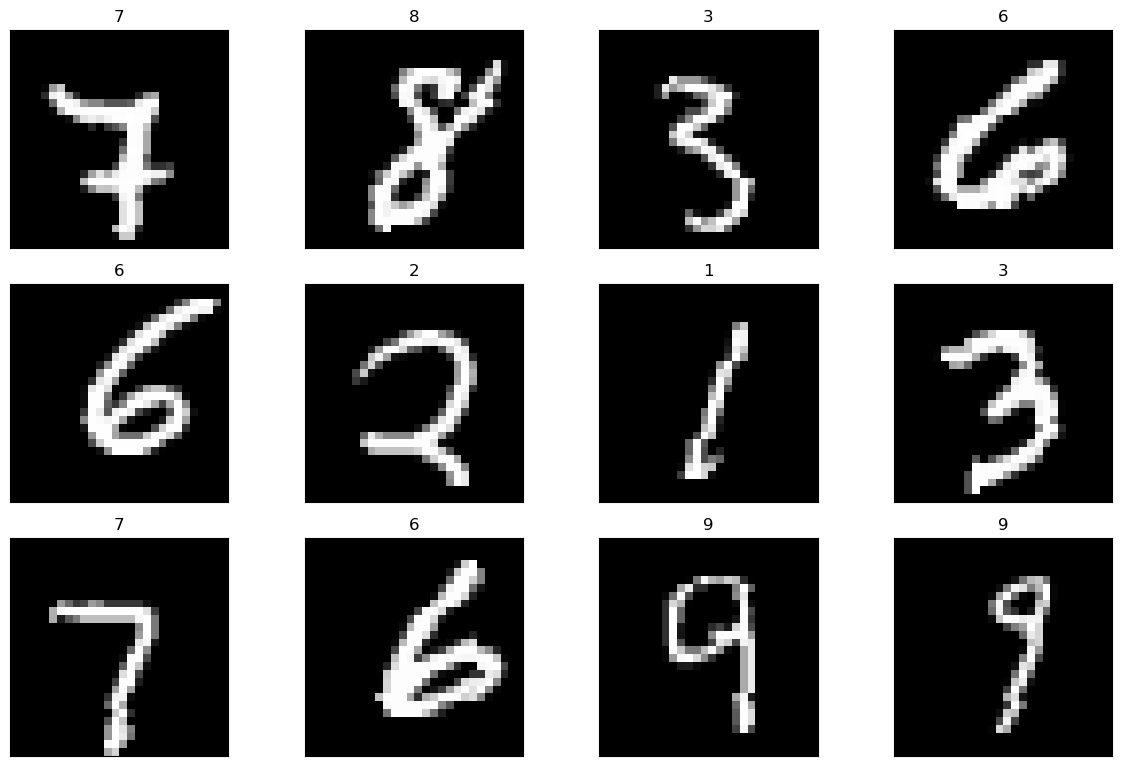

In [6]:
def visualize_batch():
    batch_data, batch_label = next(iter(train_loader))
    fig = plt.figure(figsize=(12, 8))
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.tight_layout()
        plt.imshow(batch_data[i].squeeze(0), cmap='gray')
        plt.title(batch_label[i].item())
        plt.xticks([])
        plt.yticks([])
    plt.show()

visualize_batch()

In [7]:
model = Net().to(device)  # Using improved model
total_params = model.count_parameters()
print(f"\nModel Parameters: {total_params:,}")
print(f"Model Architecture:")
print(model)
print("="*50 + "\n")

# Use AdamW for better regularization with small models
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=0)
print(f"Optimizer: SGD (lr=0.002, weight_decay=0)")


criterion = nn.CrossEntropyLoss(label_smoothing=0.02)
num_epochs = 20
scheduler = OneCycleLR(
    optimizer,
    max_lr=0.05,                        # try 0.008–0.02; 0.01 is a good start
    epochs=num_epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.2,                      # warmup portion
    div_factor=10, final_div_factor=100
    ,anneal_strategy="cos"
)



print(f"Loss: CrossEntropyLoss")
print(f"Epochs: {num_epochs}")
print(f"Batch Size: {batch_size}")
print(f"Training Samples: {len(train_data):,}")
print(f"Test Samples: {len(test_data):,}")
print("="*60 + "\n")

# Training loop
print("Starting training...")
best_test_acc = 0

for epoch in range(1, num_epochs+1):
    # Train
    train_accuracy = train(model, device, train_loader, optimizer, criterion, epoch, scheduler)

    # Test
    test_accuracy = test(model, device, test_loader, criterion)


Model Parameters: 7,784
Model Architecture:
Net(
  (conv1): Conv2d(1, 7, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(7, 7, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(7, 10, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(10, 12, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn5): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dila

  0%|          | 0/469 [00:00<?, ?it/s]


Training - Epoch 1:
  Accuracy: 34450/60000 (57.42%)
  Avg Loss: 1.3282
Test Results:
  Accuracy: 9652/10000 (96.52%)
  Avg Loss: 0.2941


  0%|          | 0/469 [00:00<?, ?it/s]


Training - Epoch 2:
  Accuracy: 50142/60000 (83.57%)
  Avg Loss: 0.6444
Test Results:
  Accuracy: 9769/10000 (97.69%)
  Avg Loss: 0.2344


  0%|          | 0/469 [00:00<?, ?it/s]


Training - Epoch 3:
  Accuracy: 52820/60000 (88.03%)
  Avg Loss: 0.5253
Test Results:
  Accuracy: 9810/10000 (98.10%)
  Avg Loss: 0.2179


  0%|          | 0/469 [00:00<?, ?it/s]


Training - Epoch 4:
  Accuracy: 53874/60000 (89.79%)
  Avg Loss: 0.4805
Test Results:
  Accuracy: 9836/10000 (98.36%)
  Avg Loss: 0.2098


  0%|          | 0/469 [00:00<?, ?it/s]


Training - Epoch 5:
  Accuracy: 54438/60000 (90.73%)
  Avg Loss: 0.4546
Test Results:
  Accuracy: 9848/10000 (98.48%)
  Avg Loss: 0.2111


  0%|          | 0/469 [00:00<?, ?it/s]


Training - Epoch 6:
  Accuracy: 54799/60000 (91.33%)
  Avg Loss: 0.4364
Test Results:
  Accuracy: 9857/10000 (98.57%)
  Avg Loss: 0.2043


  0%|          | 0/469 [00:00<?, ?it/s]


Training - Epoch 7:
  Accuracy: 55042/60000 (91.74%)
  Avg Loss: 0.4244
Test Results:
  Accuracy: 9857/10000 (98.57%)
  Avg Loss: 0.2055


  0%|          | 0/469 [00:00<?, ?it/s]


Training - Epoch 8:
  Accuracy: 55141/60000 (91.90%)
  Avg Loss: 0.4175
Test Results:
  Accuracy: 9864/10000 (98.64%)
  Avg Loss: 0.2025


  0%|          | 0/469 [00:00<?, ?it/s]


Training - Epoch 9:
  Accuracy: 55525/60000 (92.54%)
  Avg Loss: 0.4018
Test Results:
  Accuracy: 9874/10000 (98.74%)
  Avg Loss: 0.2025


  0%|          | 0/469 [00:00<?, ?it/s]


Training - Epoch 10:
  Accuracy: 55624/60000 (92.71%)
  Avg Loss: 0.3969
Test Results:
  Accuracy: 9881/10000 (98.81%)
  Avg Loss: 0.2001


  0%|          | 0/469 [00:00<?, ?it/s]


Training - Epoch 11:
  Accuracy: 55818/60000 (93.03%)
  Avg Loss: 0.3875
Test Results:
  Accuracy: 9872/10000 (98.72%)
  Avg Loss: 0.1992


  0%|          | 0/469 [00:00<?, ?it/s]


Training - Epoch 12:
  Accuracy: 55825/60000 (93.04%)
  Avg Loss: 0.3878
Test Results:
  Accuracy: 9884/10000 (98.84%)
  Avg Loss: 0.1962


  0%|          | 0/469 [00:00<?, ?it/s]


Training - Epoch 13:
  Accuracy: 56067/60000 (93.44%)
  Avg Loss: 0.3742
Test Results:
  Accuracy: 9874/10000 (98.74%)
  Avg Loss: 0.1993


  0%|          | 0/469 [00:00<?, ?it/s]


Training - Epoch 14:
  Accuracy: 56140/60000 (93.57%)
  Avg Loss: 0.3727
Test Results:
  Accuracy: 9883/10000 (98.83%)
  Avg Loss: 0.1939


  0%|          | 0/469 [00:00<?, ?it/s]


Training - Epoch 15:
  Accuracy: 56128/60000 (93.55%)
  Avg Loss: 0.3705
Test Results:
  Accuracy: 9880/10000 (98.80%)
  Avg Loss: 0.1923


  0%|          | 0/469 [00:00<?, ?it/s]


Training - Epoch 16:
  Accuracy: 56242/60000 (93.74%)
  Avg Loss: 0.3661
Test Results:
  Accuracy: 9897/10000 (98.97%)
  Avg Loss: 0.1911


  0%|          | 0/469 [00:00<?, ?it/s]


Training - Epoch 17:
  Accuracy: 56354/60000 (93.92%)
  Avg Loss: 0.3596
Test Results:
  Accuracy: 9897/10000 (98.97%)
  Avg Loss: 0.1899


  0%|          | 0/469 [00:00<?, ?it/s]


Training - Epoch 18:
  Accuracy: 56434/60000 (94.06%)
  Avg Loss: 0.3545
Test Results:
  Accuracy: 9902/10000 (99.02%)
  Avg Loss: 0.1904


  0%|          | 0/469 [00:00<?, ?it/s]


Training - Epoch 19:
  Accuracy: 56548/60000 (94.25%)
  Avg Loss: 0.3509
Test Results:
  Accuracy: 9901/10000 (99.01%)
  Avg Loss: 0.1908


  0%|          | 0/469 [00:00<?, ?it/s]


Training - Epoch 20:
  Accuracy: 56570/60000 (94.28%)
  Avg Loss: 0.3511
Test Results:
  Accuracy: 9904/10000 (99.04%)
  Avg Loss: 0.1901


In [ ]:
# Plot results
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Training Loss
axs[0, 0].plot(train_losses, 'b-', linewidth=2)
#axs[0, 0].set_title(f"Training Loss ({model_name})", fontsize=12, fontweight='bold')
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].grid(True, alpha=0.3)

# Training Accuracy
axs[1, 0].plot(train_acc, 'g-', linewidth=2)
#axs[1, 0].set_title(f"Training Accuracy ({model_name})", fontsize=12, fontweight='bold')
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Accuracy (%)")
axs[1, 0].grid(True, alpha=0.3)
axs[1, 0].axhline(y=99.4, color='r', linestyle='--', alpha=0.5, label='Target: 99.4%')
axs[1, 0].legend()

# Test Loss
axs[0, 1].plot(test_losses, 'r-', linewidth=2)
#axs[0, 1].set_title(f"Test Loss ({model_name})", fontsize=12, fontweight='bold')
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Loss")
axs[0, 1].grid(True, alpha=0.3)

# Test Accuracy
axs[1, 1].plot(test_acc, 'orange', linewidth=2)
#axs[1, 1].set_title(f"Test Accuracy ({model_name})", fontsize=12, fontweight='bold')
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_ylabel("Accuracy (%)")
axs[1, 1].grid(True, alpha=0.3)

#plt.suptitle(f"Training Results - {model_name} ({total_params:,} parameters)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Final summary
print(f"\n{'='*60}")
#print(f"FINAL SUMMARY - {model_name}")
print(f"{'='*60}")
print(f"Model Parameters: {total_params:,} (< 25,000 ✓)")
print(f"Final Training Accuracy: {train_acc[-1]:.2f}%")
print(f"Final Test Accuracy: {test_acc[-1]:.2f}%")
print(f"Best Test Accuracy: {best_test_acc:.2f}%")
print(f"First Epoch Training Accuracy: {train_acc[0]:.2f}%")

if train_acc[0] >= 99.4:
    print(f"\n✓ SUCCESS: Achieved {train_acc[0]:.2f}% training accuracy in first epoch!")
else:
    print(f"\n⚠ First epoch accuracy was {train_acc[0]:.2f}% (target was 99.4%)")
    print("  Tips to improve:")
    print("  - Try the LightweightNet or UltraLightNet models")
    print("  - Increase learning rate slightly")
    print("  - Use smaller batch size for more updates")

print(f"{'='*60}")